<a href="https://colab.research.google.com/github/withjungjh/My-Neuromatch-Academy/blob/main/LSTM_example_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set up

In [ ]:
!pip3 install torch
!pip3 install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip3 install --upgrade pandas
!pip3 install --upgrade pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 2. 주식 정보 불러오기
neural data를 가지고 하면 좋겠지만 일단 LSTM을 처음 돌려보는 상황이기 때문에, 일단 빠르게 LSTM의 실질적인 input이 어떤 데이터로 들어가는지 확인하고자 주가 정보를 이용하였다. 

In [ ]:
start = (2000, 1, 1) # 2000년 01월 01일
start = datetime.datetime(*start)
end = datetime.date.today()# 오늘

# 야후에서 google 불러오기
df = pdr.DataReader('GOOGL', 'yahoo', start, end)


`datetime.datetime(*start)` 에서 `*`의 의미는?

In [ ]:
df.head(5)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,2.604104,2.401401,2.502503,2.511011,893181924.0,2.511011
2004-08-20,2.729730,2.515015,2.527778,2.710460,456686856.0,2.710460
2004-08-23,2.839840,2.728979,2.771522,2.737738,365122512.0,2.737738
2004-08-24,2.792793,2.591842,2.783784,2.624374,304946748.0,2.624374
2004-08-25,2.702703,2.599600,2.626627,2.652653,183772044.0,2.652653


In [ ]:
df.tail(5)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-08,109.599998,107.160004,108.040001,108.379997,24238300.0,108.379997
2022-09-09,110.989998,109.019997,109.070000,110.650002,23197700.0,110.650002
2022-09-12,111.620003,109.930000,110.989998,110.860001,22966800.0,110.860001
2022-09-13,108.300003,104.089996,107.800003,104.320000,38172900.0,104.320000
2022-09-14,105.279999,103.660004,104.570000,105.000000,26366900.0,105.000000


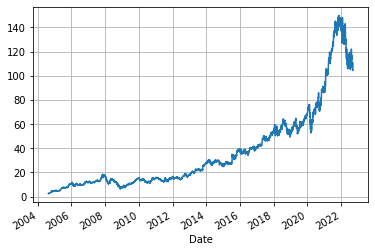

In [ ]:
df.Close.plot(grid=True)

여기에서는 pandas를 데이터로 받았다. 상황에 따라서 다른 구조의 data도 받을 텐데 그때 어떻게 적용해야 할지 생각해보도록 하자. 

# 3. Preparing Dataset


In [ ]:
X = df.drop(columns="Volume")
y = df.iloc[:, 5:6]
# y = df.iloc[:, 5] >>> column name이 나오지 않음. 

print(X)
print(y)

                  High         Low        Open       Close   Adj Close
Date                                                                  
2004-08-19    2.604104    2.401401    2.502503    2.511011    2.511011
2004-08-20    2.729730    2.515015    2.527778    2.710460    2.710460
2004-08-23    2.839840    2.728979    2.771522    2.737738    2.737738
2004-08-24    2.792793    2.591842    2.783784    2.624374    2.624374
2004-08-25    2.702703    2.599600    2.626627    2.652653    2.652653
...                ...         ...         ...         ...         ...
2022-09-08  109.599998  107.160004  108.040001  108.379997  108.379997
2022-09-09  110.989998  109.019997  109.070000  110.650002  110.650002
2022-09-12  111.620003  109.930000  110.989998  110.860001  110.860001
2022-09-13  108.300003  104.089996  107.800003  104.320000  104.320000
2022-09-14  105.279999  103.660004  104.570000  105.000000  105.000000

[4550 rows x 5 columns]
             Adj Close
Date                  
2004-0

`iloc` 무슨 함수인지 항상 까먹는다. 

## 데이터 정규화(Normalization and Standardization)

학습을 잘 시키기 위해서. 
왜 normalization을 하면 학습이 잘 되는가? 
feature scaling을 함으로서 feature scale에 덜 민감해지기 때문에. 
어떤 feature의 scale이 큰 경우에 다른 feature들을 압도할 수 있기 때문에 중요. 

- normalization through `MinMaxScaler()`
- standardization through `StandardScaler()`

In [ ]:
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X) #
y_mm = mm.fit_transform(y)

# Training data : 처음부터 4499th row까지
X_train = X_ss[:4500, :] 
y_train = y_mm[:4500, :]

# Test data: 4500th row부터 끝까지
X_test = X_ss[4500:, :]
y_test = y_mm[4500:, :]

print("Training Shape:", X_train.shape, y_train.shape)
print("Test Shape:", X_test.shape, y_test.shape)

Training Shape: (4500, 5) (4500, 1)
Test Shape: (50, 5) (50, 1)


In [ ]:
print(type(X))
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


그런데 이 상태에서는 왜 인지 블로그에서 학습이 불가능하다고 한다. 참고로 `fit_transform`을 하면서 pandas.DataFrame -> ndarray로 데이터 타입이 바뀌었다. 그런데 pytorch나 tensorflow등의 딥러닝 관련 라이브러리에서 학습이 가능하기 위해서는 tensor로 변환을 시켜줘야 하는 과정이 필요한 듯하다. 따라서 아래와 같은 과정으로 데이터 타입을 또 변환시켜준다. 

In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train)) #torch.Tensor는 input을 ndarray로만 받나? 
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train)) 
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([4500, 1, 5]) torch.Size([4500, 1])
Testing Shape torch.Size([50, 1, 5]) torch.Size([50, 1])


나는 항상 데이터 shape이 어떤 모양으로 나와서 들어가는지 헷갈린다. 아무래도 실제로 DNN structure를 짜거나 이해해야 하는 상황이 오면 단계별로 데이터 타입과 shape을 정리하면서 정보흐름이 어떻게 이어지는지 파악해야 좀 더 이해했다는 느낌을 받을 것 같다. 

# 4. GPU 준비하기 (없으면 CPU로)
이 단계가 사실 개인 컴퓨터에서 가장 까다로울 수 있는 부분이다. torch의 경우 ndivia GPU가 깔려있어야 하고 cuda를 깔거나 해야하는 부분이다. 사실 torch를 깔 때 본인의 컴퓨터 사양을 알고 거기에 맞게 pytorch를 깔아야 하는 부분이기도 해서 어쨌든 신경쓸게 많다. 나는 이런 귀찮은 걸 짧은 시간에 집중해서 하기 싫어서 colab으로 코드를 돌리고 있는 중이다.  코드는 다음과 같다. 그런데 이 코드가 과연 colab에서 정상 실행될지는 잘 모르겠다. 한번 확인해보자. 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
# print(torch.cuda.get_device_name(0)) 이 코드는 실행이 되지 않는다. 



다행히 CPU로 실행이 되는듯 한데.. 사실 colab에서도 GPU로 실행시킬 수 있다. 위에 `런타임>런타임 유형 변경` 으로 가면 실행하는 연산 프로세스? 를 CPU와 GPU , TPU 로 바꿀 수 있는 옵션이 있다. 

# LSTM network 구성하기

In [ ]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes
    self.input_size = input_size #The number of expected features in input x
    self.hidden_size = hidden_size # The number of features in the hidden state h
    self.num_layers = num_layers # num_layer = >2 means stacked LSTM
    self.seq_length = seq_length 

    self.lstm = nn.LSTM(input_size = input_size, hidden_size=hidden_size, 
                        num_layers=num_layers, batch_first=True) 
    #If batch_first=True (batch, seq, feature) instead of (seq, batch, feature) for input size
    '''
    Inputs:
      input(batch, sequence length, feature_in)
      (h_0, c_0)
        h_0: (D*num_layer, feature_cellstate or out)
        c_0: (D*num_layer, feature_out)

    Outputs:
      output(batch, sequence length, D * feature_out)
      h_n(D*num_layer, (N,) feature_out)
      c_n(D*num_layer, (N,) feature_out)

    cf. D = 2 when bidirectional LSTM, otherwise D = 1
    cf. input size and output size is different depending on the adaptation of batch.
    cf. batch is dividing input data items into several part. weight update is done after each batch finishes. 

    Question: batch를 나누는게 RNN과 같은 순서가 중요한 데이터에서는 어떤 의미를 가지는가? 
    어찌 되었든 여기에서는 시간에 따라서 batch를 나누게 될 텐데. (4500가 쓰였던 그 axis이므로) 
    '''

    self.fc_1 = nn.Linear(hidden_size, 128) #fully connected 1, output as 128 unit
    self.fc = nn.Linear(128, num_classes) #fully connected last layer output unit = num_classes

    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #cell state
    # propagate through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state

    hn = hn.view(-1, self.hidden_size) #reshapeing the data for FC layer. 
    #-1 means dependently determined number. Tenser([4,4]).view(-1, 8) -> [2,8]
    # 따라서 여기에서는 hidden_size로 데이터를 맞춰주기 위해서 이걸 사용한 것이다. 
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)

    return out

# 5. Network parameter setting

In [ ]:
num_epochs = 4500 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [ ]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss() # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) # adam optimizer

# 6. Training

In [ ]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to(device)) 
  # 아까부터 왜 다 to(device)를 붙이는지 잘 모르겠네
  optimizer.zero_grad()

  # obtain the loss fuction
  loss = loss_function(outputs, y_train_tensors.to(device))

  loss.backward() # compute gradient of loss dC/d*

  optimizer.step() # optimizer에 따라서 여러번 reevaluate 해야 하는 경우가 있고 그때 이용.
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
    # %1.5f 뜻이 뭐지? 정수부 소수부 자릿수 출력 지정 가능하다 그러는데 정확히 무슨 의미인가.
    



Epoch: 0, loss: 0.13486
Epoch: 100, loss: 0.12110
Epoch: 200, loss: 0.10915
Epoch: 300, loss: 0.09884
Epoch: 400, loss: 0.09003
Epoch: 500, loss: 0.08255
Epoch: 600, loss: 0.07628
Epoch: 700, loss: 0.07105
Epoch: 800, loss: 0.06675
Epoch: 900, loss: 0.06325
Epoch: 1000, loss: 0.06040
Epoch: 1100, loss: 0.05811
Epoch: 1200, loss: 0.05628
Epoch: 1300, loss: 0.05486
Epoch: 1400, loss: 0.05375
Epoch: 1500, loss: 0.05290
Epoch: 1600, loss: 0.05223
Epoch: 1700, loss: 0.05164
Epoch: 1800, loss: 0.05110
Epoch: 1900, loss: 0.05062
Epoch: 2000, loss: 0.05013
Epoch: 2100, loss: 0.04948
Epoch: 2200, loss: 0.04875
Epoch: 2300, loss: 0.04804
Epoch: 2400, loss: 0.04732
Epoch: 2500, loss: 0.04656
Epoch: 2600, loss: 0.04578
Epoch: 2700, loss: 0.04496
Epoch: 2800, loss: 0.04411
Epoch: 2900, loss: 0.04323
Epoch: 3000, loss: 0.04232
Epoch: 3100, loss: 0.04138
Epoch: 3200, loss: 0.04040
Epoch: 3300, loss: 0.03940
Epoch: 3400, loss: 0.03837
Epoch: 3500, loss: 0.03732
Epoch: 3600, loss: 0.03624
Epoch: 3700, 

이거를 처음에는 epoch = 10000으로 했더니 무슨 말도 안되게 0.00000 으로 loss 값이 나와서 아 이건 아니다 싶어서 epoch 수를 줄였다. 4500 으로 일단 했는데 어떻게 나오는지 한 번 보자. Epoch: 4400, loss: 0.02692

# Prediction
여기는 코드에 대한 이해 없이 그냥 붙였더니..

In [ ]:
df_X_ss = ss.transform(df.drop(columns='Volume'))
df_y_mm = mm.transform(df.iloc[:, 5:6])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

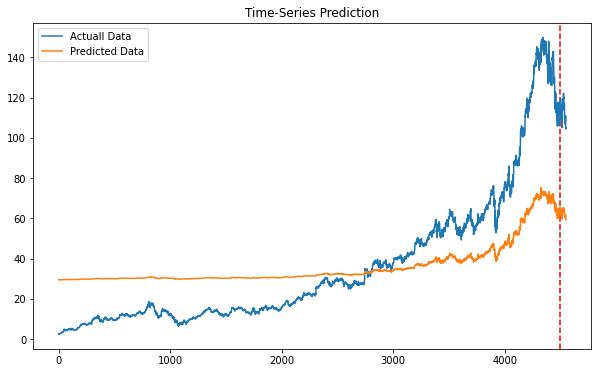

In [ ]:
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=4500, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 


완전 똑같지는 않은데 점선 이후의 지점의 추세는 같다. 그런데 RNN이라서 앞의 데이터는 완벽하게 따라야 하니까 그런 건가? loss가 0이 되는 지점까지만 한 번 해보자. 


Epoch: 0, loss: 0.01910
Epoch: 100, loss: 0.01798
Epoch: 200, loss: 0.01690
Epoch: 300, loss: 0.01586
Epoch: 400, loss: 0.01484
Epoch: 500, loss: 0.01386
Epoch: 600, loss: 0.01291
Epoch: 700, loss: 0.01199
Epoch: 800, loss: 0.01111
Epoch: 900, loss: 0.01026
Epoch: 1000, loss: 0.00945
Epoch: 1100, loss: 0.00868
Epoch: 1200, loss: 0.00794
Epoch: 1300, loss: 0.00725
Epoch: 1400, loss: 0.00660
Epoch: 1500, loss: 0.00598
Epoch: 1600, loss: 0.00541
Epoch: 1700, loss: 0.00488
Epoch: 1800, loss: 0.00439
Epoch: 1900, loss: 0.00394
Epoch: 2000, loss: 0.00352
Epoch: 2100, loss: 0.00314
Epoch: 2200, loss: 0.00280
Epoch: 2300, loss: 0.00249
Epoch: 2400, loss: 0.00221
Epoch: 2500, loss: 0.00197
Epoch: 2600, loss: 0.00175
Epoch: 2700, loss: 0.00156
Epoch: 2800, loss: 0.00140
Epoch: 2900, loss: 0.00125
Epoch: 3000, loss: 0.00113
Epoch: 3100, loss: 0.00102
Epoch: 3200, loss: 0.00093
Epoch: 3300, loss: 0.00085
Epoch: 3400, loss: 0.00078
Epoch: 3500, loss: 0.00072
Epoch: 3600, loss: 0.00067
Epoch: 3700, 

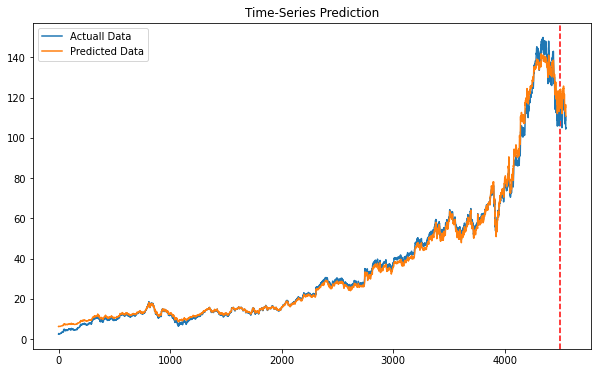

In [ ]:
num_epochs = 6000 #1000 epochs

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to(device)) 
  # 아까부터 왜 다 to(device)를 붙이는지 잘 모르겠네
  optimizer.zero_grad()

  # obtain the loss fuction
  loss = loss_function(outputs, y_train_tensors.to(device))

  loss.backward() # compute gradient of loss dC/d*

  optimizer.step() # optimizer에 따라서 여러번 reevaluate 해야 하는 경우가 있고 그때 이용.
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
    # %1.5f 뜻이 뭐지? 정수부 소수부 자릿수 출력 지정 가능하다 그러는데 정확히 무슨 의미인가.

train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=4500, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

어.. 이거 이어서 학습이 된건가? 왜이렇게 처음부터 loss 값이 낮지.. ㅋㅋㅋ 잘 모르겠다. 일단 이번 실습은 이 정도 선에서 마무리. 

# Reference
https://coding-yoon.tistory.com/131

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

https://pytorch.org/docs/stable/generated/torch.Tensor.view.html

https://pytorch.org/docs/stable/generated/torch.Tensor.to.html

https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html

https://pytorch.org/docs/stable/optim.html


